In [31]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [32]:
#hide
from fastbook import *

## Multi-Label Classification


Our goal is to come up with a model that can identify the categories of objects in images that may not contain exactly one type of object. There may be more than one kind of object, or there may be no objects at all in the classes that we're looking for.

Multi-label classifiers are more widely applicable than single-label classifiers because they solve the problem of giving an incorrect answer when the model doesn't recognize the image. 

We'll find that the architecture of the model does not change from last time, only the loss function changes

We're going to use the PASCAL dataset, which can have mmore than one kind of classified object per image

In [33]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

This dataset is different to the ones from before, it uses a CSV file telling us what labels to use for each image. The list of categories in each image is shown as a space-delimited string.

In [34]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


Constructing a datablock

We'll start with the simplest case, a data block created with no parameters:

In [35]:
dblock = DataBlock()

We can create a `Datasets` object from this. All we need is a source (the DataFrame):

In [36]:
dsets = dblock.datasets(df)

This contains a train and a valid datasset, which we can index into:

In [37]:
len(dsets.train), len(dsets.valid)

(4009, 1002)

In [38]:
x,y = dsets.train[0]
x,y

(fname           006028.jpg
 labels      bicycle person
 is_valid              True
 Name: 3029, dtype: object,
 fname           006028.jpg
 labels      bicycle person
 is_valid              True
 Name: 3029, dtype: object)

Currently this just returns a row of hte DataFrame twice. By default, the data block assumes we have two things: input and target.

We need to get the appropriate fields from the DataFrame, which we do by passsing get_x and get_y functions:

In [39]:
x['fname']

'006028.jpg'

In [40]:
dblock = DataBlock(
    get_x = lambda r: r['fname'],
    get_y = lambda r: r['labels']
)

dsets = dblock.datasets(df)
dsets.train[0]

('009603.jpg', 'boat person')

Here is the equivalent without using lambda functions:

In [41]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']

dblock = DataBlock(
    get_x = get_x,
    get_y = get_y
)

dsets = dblock.datasets(df)
dsets.train[0]

('008553.jpg', 'train')

The independent variable will need to be converted into a complete path so that we can open it as an image, and the dependent variable will need to be split on the space character so that it becomes a list:

In [42]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')

dblock = DataBlock(
    get_x = get_x,
    get_y = get_y
)

dsets = dblock.datasets(df)
dsets.train[0]

(Path('/home/one6ix/.fastai/data/pascal_2007/train/000125.jpg'),
 ['bicycle', 'person'])

To open the image and do conversion to tensors, we need to use a set of transforms; block types will provide us with those. 

We can use the same ones we've used previously with one exception:
- ImageBlock will work fine again, because we have a path that points to a valid image
- CategoryBlock is not going to work because it returns a single integer, but we need to have multiple labels for each item

Instead, we'll use a MultiCategoryBlock
- It expects to receive a list of string

In [43]:
dblock = DataBlock(
    blocks = (ImageBlock, MultiCategoryBlock),
    get_x = get_x,
    get_y = get_y
)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x281,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]))

CategoryBlock used a single integer representing which category was present based on its location in our vocab

MultiCategoryBlock uses one-hot encoding:
- A one in any position in the list of zeroes represents which category is present
- We can't easily use a list of category indices since each list would be a different length, and PyTorch requires tensors where everything has to be the same length

We can see what the categories represent for this example using the torch.where function, which tells us all of the indices where our condition is true or false:

In [44]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#2) ['chair','sofa']

We haven't taken into account the validation set yet, found in the is_valid column. Right now, the DataBlock has been using a random split by default.

To explicitly choose the elements of our validation set, we need to write a function and pass it to splitter (or use one of fastai's predefined functions or classes).

It will take the items (our whole DataFrame) and must return two (or more) lists of integers:

In [45]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(
    blocks = (ImageBlock, MultiCategoryBlock),
    splitter = splitter,
    get_x = get_x,
    get_y = get_y
)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

Now that we've confirmed that the individual items look ok, we need to ensure that every item is of the same size.

We can use RandomResizedCrop to do this:

In [46]:
dblock = DataBlock(
    blocks = (ImageBlock, MultiCategoryBlock),
    splitter = splitter,
    get_x = get_x,
    get_y = get_y,
    item_tfms=RandomResizedCrop(128, min_scale=0.35)
)

dls = dblock.dataloaders(df)

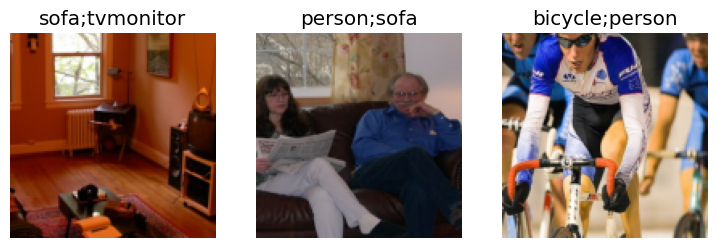

In [47]:
dls.show_batch(nrows=1, ncols=3)

Nothing will change when we create our Learner but fastai library will pick a new loss function for us: binary cross-entropy

## Binary Cross Entropy

Now we need to create a Learner, which consists of four things:
- The model
- A DataLoaders object
- An optimizer
- The loss function to use

We've got the first three, since we're going to use a resnet variation, a dataloaders object, and we'll use SGD. Now we need to come up with a suitable loss function. 

Let's first create a Learner and look at its activations

In [48]:
learn = vision_learner(dls, resnet18)

The model in a Learner is usually an object of a class inheriting from nn.Module so calling it using parentheses will return the activations of the model.

We'll pass it the independent variable as a mini-batch from our DataLoader:

In [49]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

It has this shape because the batch size is 64, and there are the probabilities of 20 categories to calculate

In [50]:
activs[0]

TensorImage([ 1.9494e+00, -1.7092e+00, -2.4534e+00,  5.9009e-01, -2.7431e-03, -3.4094e+00,  9.4157e-01, -7.2187e-01,  3.1886e-01, -7.2162e-02, -1.4452e+00, -5.4676e-01,  1.0467e+00,  1.9238e+00,
              6.4257e-01,  1.0867e+00,  3.4676e-01,  1.1965e+00,  1.5891e+00,  3.4477e-01], grad_fn=<AliasBackward0>)

We'll then using the sigmoid and log function to calculate a loss based on this:

In [51]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

PyTorch provides two versions of BCE:
- F.binary_cross_entropy and its module equivalent nn.BCELoss which calculate cross-entropy on a one-hot-encoded target but do not incldue the initial sigmoid
- F.binary_cross_entropy_with_logits (nn.BCEWithLogitsLoss) do both sigmoid and binary cross-entropy in a single function

For a single-label dataset PyTorch also provides two version of cross entropy:
- F.nll_loss (nn.NLLLoss) which do not include the initial softmax
- F.cross_entropy (nn.CrossEntropyLoss) includes the initial softmax

Therefore, since we have a one-hot-encoded target, we'll use BCEWithLogitsLoss

In [54]:
loss_func = nn.BCEWithLogitsLoss()     
loss = loss_func(activs, Tensor(y))     
loss

TensorImage(1.0760, grad_fn=<AliasBackward0>)

We'll also need to change the metric we use compared to last chapter because our accuracy function will no longer work:

```python
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred = inp.argmax(dim=axis)
    return (pred == targ).float().mean()
```

The old accuracy function selected a class based on whichever one had the highest activation (what argmax does). It doesn't work here because we could have more than one prediction on a single image. So, after applying the sigmoid function (to make them between 0 and 1), we need to decide which are 0 and which are 1 using a threshold. Each value above the threshold will be counted as a 1, each value below the threshold will be counted as a 0.

```python
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()
```

If we pass this funciton in directly, it will use the default threshold which is 0.5. We may want to adjust that default and create a new version of accuracy_multi with a different value for its default. To do this, we can use Python's method partial. 
- partial allows us to bind a function with some arguments or keyword arguments, making a new function that, whenever it is called, always includes those arguments

In [55]:
def say_hello(name, say_what="Hello"): return f"{say_what} {name}."
say_hello('Jeremy'),say_hello('Jeremy','Ahoy!')

('Hello Jeremy.', 'Ahoy! Jeremy.')

In [56]:
f = partial(say_hello, say_what="Bonjour")
f("Jeremy"),f("Sylvain")

('Bonjour Jeremy.', 'Bonjour Sylvain.')

We can now train our model so we'll set the accuracy threshold to 0.2 for our metric:

In [58]:
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.962218,0.704114,0.228586,00:04
1,0.834627,0.541678,0.296096,00:04
2,0.607377,0.194340,0.824163,00:04
3,0.359751,0.114498,0.946494,00:04


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.126686,0.105841,0.950717,00:05
1,0.111515,0.095399,0.956335,00:05
2,0.094922,0.093601,0.959004,00:05


Picking the right threshold is super important. 
- Low threshold means often failing to select correctly labeled objects
- High threshold means only selecting object which our model is very confident about

We can see this by changing our metric and calling validate, which returns the validation loss and metrics:

In [59]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.09360073506832123,0.9413145184516907]

In [60]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.09360073506832123,0.9442429542541504]

We can find the best threshold by trying a few levels and seeing what works best (can be made a lot faster by grabbing the predictions once):


In [61]:
preds,targs = learn.get_preds()

We can then call the metric directly.

Note: By default get_preds applies the output activation function (sigmoid) so we need to tell accuracy_multi not to apply it:

In [62]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorBase(0.9598)

We can use this approach to find the best threshold level:

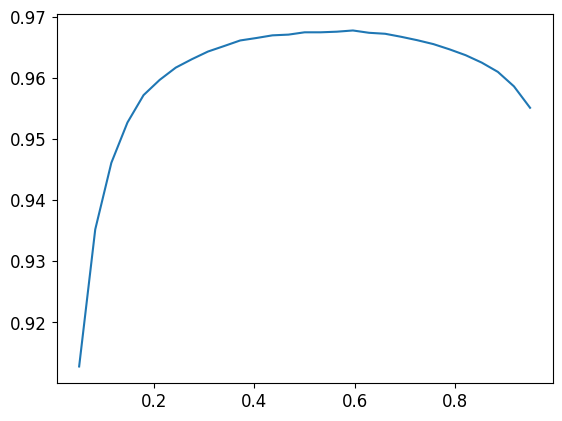

In [63]:
xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs)

Using the validation set to pick a hyperparameter (the threshold) is ok in this case because it results in a smooth curve therefore we're not picking some inappropriate outlier.

Make sure to know difference between theory (don't try lots of hyperparameter values or you might overfit the validation set) and practice (if the relationship is smooth, then its fine to do this).

## Regression

To be able to craft our own novel solutions to novel problems, we need to really understand the data block API. To do this, we'll create a key point model to perform image regression.

Essentially, we will predict the location of the center of a person's face.

We'll begin by downloading the dataset as usual:

In [64]:
path = untar_data(URLs.BIWI_HEAD_POSE)
Path.BASE_PATH = path

Let's see what we have:

In [65]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj'),Path('06'),Path('06.obj'),Path('07'),Path('07.obj'),Path('08'),Path('08.obj'),Path('09'),Path('09.obj'),Path('10'),Path('10.obj')...]

We have 24 directories numbered from 01 to 24 (corresponding to the different people photographed). Looking at one of the directories:

In [66]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt'),Path('01/frame_00007_rgb.jpg'),Path('01/frame_00008_pose.txt'),Path('01/frame_00008_rgb.jpg'),Path('01/frame_00009_pose.txt'),Path('01/frame_00009_rgb.jpg'),Path('01/frame_00010_pose.txt'),Path('01/frame_00010_rgb.jpg'),Path('01/frame_00011_pose.txt'),Path('01/frame_00011_rgb.jpg'),Path('01/frame_00012_pose.txt')...]

We have different frames, each come with an image (_rgb.jpg) and a pose file (_pose.txt).

We can get all the image files recursively with get_image_files, then write a function that converts an image filename to its associated pose file:

In [67]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('21/frame_00381_pose.txt')

Looking at the first image:

In [68]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

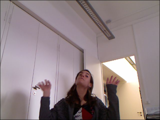

In [69]:
im.to_thumb(160)

The format of the pose text file is explained on the website which shows the location of the center of the head. We don't really care about the details so we'll just use a premade function to extract the head center point:

In [70]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

The function returns the coordinates as a tensor of two items:

In [71]:
get_ctr(img_files[0])

tensor([349.6638, 301.8325])

We can pass this function to DataBlock as get_y, since its responsible for labeling each tiem. We'll also resize the images to half their input size to speed up training.

We should not use a random splitter because the same people appear in multiple images but we want to ensure that our model can generalize to people that it hasn't seen yet. Each folder contains the images for one person. Thus, we can create a splitter function that returns true for just one person, resulting in a validation set containing just that person's images.

We also need to use a PointBlock so fastai knows that the labels represent coordinates. Thus, when we do data augmentation, it should do the same augmentation to these coordinates as it does to the images

In [72]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items = get_image_files,
    get_y = get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=aug_transforms(size=(240,320))
)

Before doing any modelling well look at the data to confirm it seems ok:

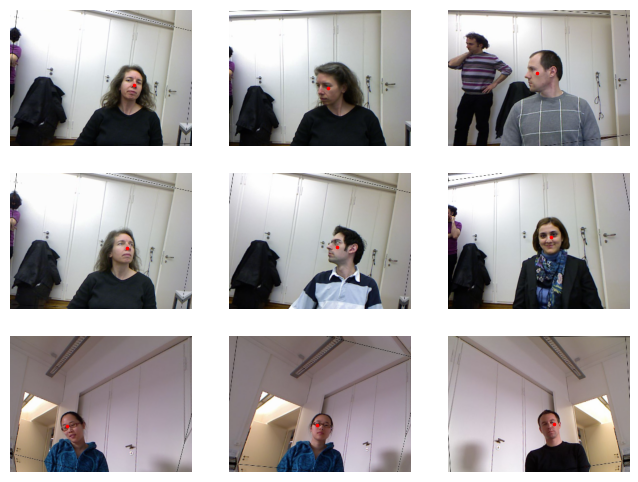

In [73]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [74]:
xb,yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

Next we'll create a Learner. We'll use the same function as before, with one new parameter, and we will be ready to train.

We use vision_learner to create our Learner and we'll set y_range to tell fastai the range of our targets (-1, +1 since coordinates are rescaled to that range)

In [75]:
learn = vision_learner(dls, resnet18, y_range=(-1,1))

The final layer of the model is sigmoid_range when y_range is defined. It forces the model to output activations in the range (lo,hi). It is defined as follows:

In [76]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi - lo) + lo

We didn't specify a loss function so let's see what fastai chooses for us:

In [77]:
learn.loss_func

FlattenedLoss of MSELoss()

Makes sense, when coordinates are used as the dependent variable, we're likely trying to predict something as close as possible, which is basically what MSELoss (mean squared error loss) does. 

We can find a good learning rate with the learning rate finder:

/home/one6ix/Documents/GitHub/fastbook/.venv/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_lo

SuggestedLRs(valley=0.0030199517495930195)

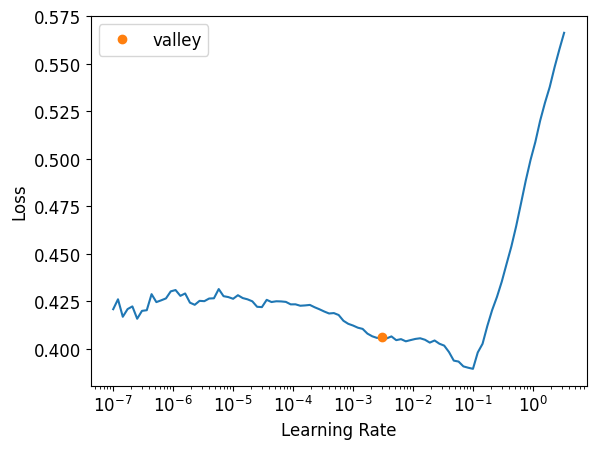

In [78]:
learn.lr_find()

Thus, we'll try an lr of 1e-2.

In [79]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.050719,0.032120,00:23


epoch,train_loss,valid_loss,time
0,0.008430,0.002933,00:32
1,0.003156,0.000130,00:31
2,0.001486,0.000060,00:31


Generally when we use this model we'll get a loss of around 0.00001. This corresponds to an average coordinate prediction error of:

In [81]:
math.sqrt(0.0001)

0.01

Let's also look at our results with Learner.show_results

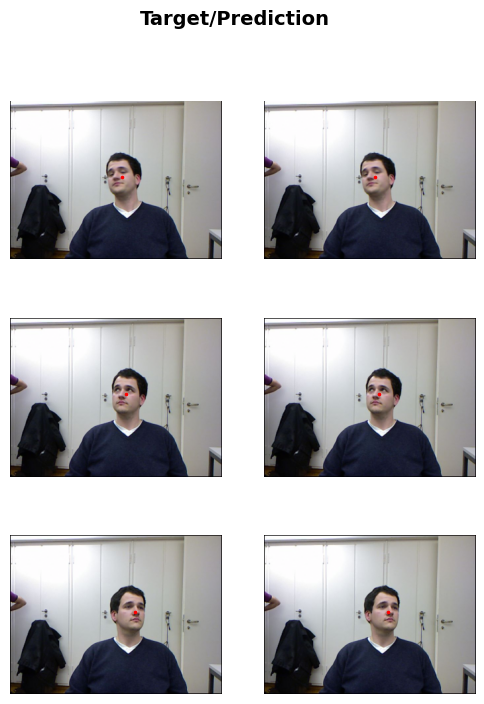

In [82]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))